# Prototype Geochemistry module

In [71]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [52]:
def get_variables(df):
    """List all variables"""
    value = list( df.columns )
    return value

def get_ignorefeatures(df):
    """List all ignored features"""
    value = [
        'id', 
        'result_master_id',
        'DDH_name',
        'from_m',
        'to_m',
        'Sample_Length_m',
        'Scan_Length_m',
        'Scan_Recovery_pct',
        'Comp(c/s)', 
        'Rayl(c/s)', 
        'LT(secs)',
        'minaloggerlink']
    additional = (
        [s for i, s in enumerate(get_variables(df)) if "mdl" in s] +
        [s for i, s in enumerate(get_variables(df)) if "2SE" in s]
        )
    # Remove clusters from feature list 
    # [s for i, s in enumerate(self.get_variables()) if "_Cluster" in s] 
    value = value + additional
    return value

def get_features(df):
    """List all features"""

    value = list( 
        set( get_variables(df) ) - set( get_ignorefeatures(df)  )
        )
    return value 

def aggregate(df, output="stack"):
    """Aggregate by cluster
    
    df: pandas.DataFrame
    
    output: str, default = "stack"
        Output format must be "stack" | "unstack"

    """
    df = df.loc[:,get_features(df)]\
        .groupby(["hclust_Cluster"])\
        .agg(["median"])\
        .reset_index()  

    df.columns = [' '.join(col).strip() for col in df.columns.values]
    df = df.T   
    names = df.iloc[0,:].values

    df = df.drop(df.index[0])
    df.columns = names
    df["type"] = df.index.str.extract(r'(ppm|pct)').values
    df.index.name = "element"
    df = df.sort_values(by=["type","element"])
    df = df.reset_index()

    if output == "stack":
        df = df.reset_index()\
            .melt(id_vars=["element", "type"], value_vars=names, var_name="cluster")\
            .sort_values(["element", "cluster"])\
            .reset_index(drop=True)

    df.columns = df.columns.str.lower()

    return df   


def evaluate_metric_byelement(df, metric="std"):
    """Evaluate element variation across clusters"""
    
    vars = ["element", "type", "value"]

    metric = df.loc[:, vars]\
            .groupby(["element", "type"])\
            .agg([metric])\
            .reset_index()  

    metric.columns = vars
    
    return metric
 
    #cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
    #metric = df.loc[:, vars]\
    #        .groupby(["element", "type"])\
    #        .agg([('cv', cv)])\
    #        .reset_index()  



In [13]:
sys.path.append("../../")
filepath   = '../../data/OOLDEA2_1m_intervals-labeled.csv'
labeled = pd.read_csv( filepath )

In [14]:
labeled.head()

,id,result_master_id,DDH_name,from_m,to_m,Sample_Length_m,Scan_Length_m,Scan_Recovery_pct,Comp(c/s),Rayl(c/s),LT(secs),Al_pct,Al_2SE_pct,Al_mdl_pct,Si_pct,Si_2SE_pct,Si_mdl_pct,P_ppm,P_2SE_ppm,P_mdl_ppm,S_pct,S_2SE_pct,S_mdl_pct,Cl_ppm,Cl_2SE_ppm,Cl_mdl_ppm,K_pct,K_2SE_pct,K_mdl_pct,Ca_pct,Ca_2SE_pct,Ca_mdl_pct,Ti_ppm,Ti_2SE_ppm,Ti_mdl_ppm,V_ppm,V_2SE_ppm,V_mdl_ppm,Cr_ppm,Cr_2SE_ppm,Cr_mdl_ppm,Mn_ppm,Mn_2SE_ppm,Mn_mdl_ppm,Fe_pct,Fe_2SE_pct,Fe_mdl_pct,Ni_ppm,Ni_2SE_ppm,Ni_mdl_ppm,Cu_pct,Cu_2SE_pct,Cu_mdl_pct,Zn_pct,Zn_2SE_pct,Zn_mdl_pct,Ga_ppm,Ga_2SE_ppm,Ga_mdl_ppm,As_ppm,As_2SE_ppm,As_mdl_ppm,Se_ppm,Se_2SE_ppm,Se_mdl_ppm,Rb_ppm,Rb_2SE_ppm,Rb_mdl_ppm,Sr_ppm,Sr_2SE_ppm,Sr_mdl_ppm,Y_ppm,Y_2SE_ppm,Y_mdl_ppm,Zr_ppm,Zr_2SE_ppm,Zr_mdl_ppm,Nb_ppm,Nb_2SE_ppm,Nb_mdl_ppm,Mo_ppm,Mo_2SE_ppm,Mo_mdl_ppm,Ba_ppm,Ba_2SE_ppm,Ba_mdl_ppm,La_ppm,La_2SE_ppm,La_mdl_ppm,Ce_ppm,Ce_2SE_ppm,Ce_mdl_ppm,Pb_pct,Pb_2SE_pct,Pb_mdl_pct,U_ppm,U_2SE_ppm,U_mdl_ppm,minaloggerlink,hclust_Cluster
0,69232,38,OOLDEA2,13,14,1,0.2401,24.01,2613.187,715.3073,22.69,2.4882,0.6711,0.8397,22.3157,0.7263,0.2942,0.0,0.0,0.0,0.3293,0.0857,0.0857,0.0,0,0,2.1815,0.0337,0.0067,1.1516,0.0167,0.0036,4394.9931,77.9360,17.3857,101.98,13.27,10.31,41.43,9.57,13.31,997.5006,24.7826,10.8424,4.6119,0.0128,0.0013,33.92,2.65,2.87,0.0047,0.0006,0.0009,0.0069,0.0004,0.0004,16.84,2.33,3.26,0.0,3.86,5.72,0.0,0.0003,0.0005,110.82,6.34,7.45,183.08,8.34,6.53,17.90,8.74,12.56,246.13,11.49,12.17,0.0,8.85,13.49,0.0,9.9,14.93,564.78,260.39,75.76,144.19,88.37,35.04,87.31,54.90,40.99,0.0029,0.0017,0.0025,22.97,15.03,20.40,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0
1,69233,38,OOLDEA2,14,15,1,0.4056,40.56,2498.827,653.7424,37.04,5.4625,0.6962,0.5558,23.3913,0.6344,0.2257,0.0,0.0,0.0,1.5906,0.2473,0.0677,0.0,0,0,2.0354,0.0278,0.0057,4.2996,0.0382,0.0031,3972.9395,65.3464,15.5872,97.18,11.19,9.17,61.02,8.89,11.63,1374.6612,29.4294,9.2935,5.9728,0.0127,0.0010,35.88,2.31,2.42,0.0047,0.0005,0.0007,0.0060,0.0003,0.0003,20.55,1.95,2.69,0.0,3.22,4.80,0.0,0.0003,0.0004,101.26,5.26,6.11,186.29,7.73,5.36,25.48,7.69,10.26,241.73,9.88,9.91,0.0,7.27,11.02,0.0,0.0,0.00,748.25,221.11,69.75,98.25,69.88,31.75,70.23,45.22,36.78,0.0030,0.0014,0.0021,20.18,12.16,16.75,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0
2,69234,38,OOLDEA2,15,16,1,0.6329,63.29,2869.263,702.2439,47.39,2.9798,0.5095,0.5622,23.6034,0.5939,0.2036,0.0,0.0,0.0,1.0650,0.1690,0.0604,0.0,0,0,2.4316,0.0300,0.0048,2.5947,0.0242,0.0026,3402.2079,54.5552,13.1892,87.11,9.43,7.79,43.69,7.46,10.09,948.7098,20.9103,8.5190,5.0235,0.0103,0.0009,37.76,2.14,2.13,0.0066,0.0005,0.0007,0.0052,0.0003,0.0003,22.75,1.76,2.39,0.0,2.73,4.18,0.0,0.0002,0.0004,124.88,5.15,5.35,202.79,7.90,4.71,9.16,6.21,9.04,265.10,9.75,8.75,0.0,6.34,9.53,0.0,7.1,10.50,496.97,171.95,56.96,88.25,56.43,26.37,113.00,36.45,30.90,0.0032,0.0012,0.0019,31.67,10.89,14.70,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0
3,69235,38,OOLDEA2,16,17,1,0.6143,61.43,2594.439,641.5786,48.72,4.0648,0.5209,0.4220,19.1905,0.5057,0.1687,0.0,0.0,0.0,0.0773,0.0377,0.0505,0.0,0,0,1.8808,0.0243,0.0040,1.1856,0.0132,0.0022,2410.0222,40.7665,10.1916,57.86,7.19,6.26,23.88,5.73,8.09,431.3725,11.6169,6.9701,3.2593,0.0076,0.0008,25.37,1.62,1.66,0.0040,0.0004,0.0005,0.0035,0.0002,0.0002,16.84,1.38,1.91,0.0,0.00,0.00,0.0,0.0002,0.0003,104.59,4.30,4.45,158.59,6.25,3.92,0.00,0.00,0.00,200.86,7.75,7.33,0.0,0.00,0.00,0.0,6.0,8.82,367.05,136.17,45.81,57.82,45.34,21.19,73.96,29.13,24.85,0.0036,0.0010,0.0015,24.23,9.12,12.22,https://minalogger.com/viewer/?project=WESTERN...,Cluster 0
4,69236,38,OOLDEA2,17,18,1,0.4486,44.86,2578.841,647.0553,43.21,3.4820,0.5105,0.4811,15.7049,0.4627,0.1896,0.0,0.0,0.0,0.2257,0.0546,0.0538,0.0,0,0,2.0808,0.0269,0.0042,0.9481,0.0117,0.0024,1746.3668,33.5724,10.7911,30.69,6.87,6.71,16.87,6.03,8.61,1443.5878,29.4294,6.9701,3.2247,0.0079,0.0008,20.59,1.54,1.78,0.0041,0.0004,0.0005,0.0038,0.0002,0.0003,12.19,1.45,2.04,0.0,0.00,0.00,0.0,0.0002,0.0003,151.94,5.48,4.86,129

In [66]:
df = aggregate(labeled, output="unstack")
df

,element,cluster 0,cluster 1,cluster 2,type
0,Al_pct median,4.33055,4.7494,5.90025,pct
1,Ca_pct median,2.23275,0.7056,1.0129,pct
2,Cu_pct median,0.004,0.0049,0.0048,pct
3,Fe_pct median,8.24355,12.35935,14.6473,pct
4,K_pct median,2.0581,1.71665,1.9208,pct
5,Pb_pct median,0.001,0.0,0.0,pct
6,S_pct median,0.1504,0.0,0.0,pct
7,Si_pct median,19.42075,21.3501,25.1516,pct
8,Zn_pct median,0.0051,0.005,0.0074,pct
9,As_ppm median,0.0,8.285,11.825,ppm


In [68]:
df = aggregate(labeled, output="stack")
df.head()

,element,type,cluster,value
0,Al_pct median,pct,Cluster 0,4.33055
1,Al_pct median,pct,Cluster 1,4.7494
2,Al_pct median,pct,Cluster 2,5.90025
3,As_ppm median,ppm,Cluster 0,0.0
4,As_ppm median,ppm,Cluster 1,8.285


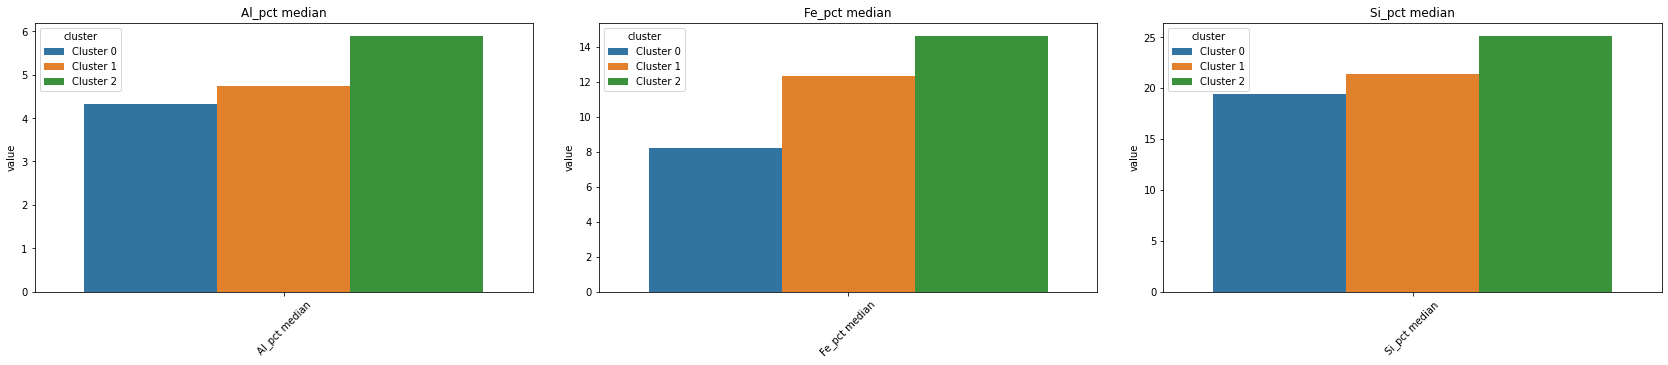

In [65]:
filters = [
    "Al_pct median", 
    "Fe_pct median", 
    "Si_pct median", 
    ]

n = len( filters )

fig, ax = plt.subplots(1,n, figsize=(24,5) )
fig.tight_layout(pad=3.5)
for i,filter in enumerate(filters):

    this = df[df["element"].str.contains(filters[i])]

    ax = ax.flatten()
    sns.barplot(ax=ax[i], x="element", y="value", hue="cluster", data=this)

    ax[i].tick_params(axis='x', rotation=45)
    
    ax[i].set_title(filter)
    ax[i].set_xlabel("")

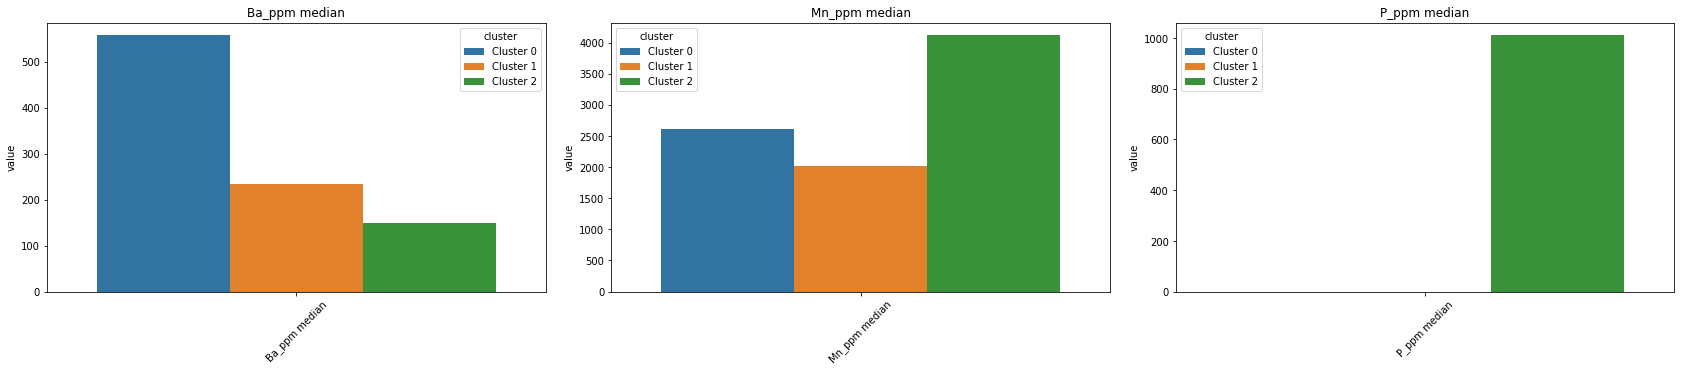

In [70]:
filters = [
    "Ba_ppm median", 
    "Mn_ppm median", 
    "P_ppm median", 
    ]

n = len( filters )

fig, ax = plt.subplots(1,n, figsize=(24,5) )
fig.tight_layout(pad=3.5)
for i,filter in enumerate(filters):

    this = df[df["element"].str.contains(filters[i])]

    ax = ax.flatten()
    sns.barplot(ax=ax[i], x="element", y="value", hue="cluster", data=this)

    ax[i].tick_params(axis='x', rotation=45)
    
    ax[i].set_title(filter)
    ax[i].set_xlabel("")

In [92]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100

vars = ["element", "type", "value"]

metric = df.loc[:, vars]\
        .groupby(["element", "type"])\
        .agg([('cv', cv)])\
        .reset_index()  

metric = df.loc[:, vars]\
        .groupby(["element", "type"])\
        .agg(["std"])\
        .reset_index()  


metric.columns = vars
metric.head()


,element,type,value
0,Al_pct median,pct,0.812799
1,As_ppm median,ppm,6.069095
2,Ba_ppm median,ppm,214.980925
3,Ca_pct median,pct,0.807739
4,Ce_ppm median,ppm,54.848063


In [93]:

metric[metric["type"] == "pct"]\
    .sort_values( by="value", ascending=False )\
    .head()


,element,type,value
8,Fe_pct median,pct,3.245061
21,Si_pct median,pct,2.915946
0,Al_pct median,pct,0.812799
3,Ca_pct median,pct,0.807739
10,K_pct median,pct,0.171812


In [94]:

metric[metric["type"] == "ppm"]\
    .sort_values( by="value", ascending=False )\
    .head()

,element,type,value
12,Mn_ppm median,ppm,1080.266502
16,P_ppm median,ppm,583.557391
23,Ti_ppm median,ppm,220.830269
2,Ba_ppm median,ppm,214.980925
4,Ce_ppm median,ppm,54.848063
